# Computing Metacells - One-Pass Process

In this vignette we will demonstrate how to compute metacells starting with brand-new data, but heavily relying on previous analysis of similar data. This is in contrast to the full iterative process, where we repeatedly revise our decisions. Here in the one-pass vignette we assume that magically all our decisions were correct, so we can immediately compute the results (in practice, we simply applied the final decisions from the iterative process vignette).

In the real world, the actual process used will fall between these two extremes. That is, by using prior knowledge that applies to the specific data set, some of the decisions we make below will be correct from the start, but most likely, some still need to be revised, andn require some iterations to finalize.

To remove doubt, the results presented here are **not** suitable for use in any serious analysis. This is an example of the process, nothing more.

## 1. Setup

We'll start with importing the python libraries we'll be using and setup some global configuration. Just importing takes a few seconds, mainly because Python's importing of C++ extensions with a large number of functions is inefficient.

In [1]:
%%time
import anndata as ad             # For reading/writing AnnData files
import matplotlib.pyplot as plt  # For plotting
import metacells as mc           # The Metacells package
import numpy as np               # For array/matrix operations
import pandas as pd              # For data frames
import os                        # For filesystem operations
import seaborn as sb             # For plotting
import scipy.sparse as sp        # For sparse matrices
import shutil                    # for filesystem operations
from math import hypot           # For plotting

CPU times: user 6.76 s, sys: 10.5 s, total: 17.3 s
Wall time: 5.71 s


Then, configure the packages we use. Feel free to tweak as necessary.

In [2]:
%%time

# Use SVG for scalable low-element-count diagrams.
%config InlineBackend.figure_formats = ["svg"]

# A matter of personal preference.
sb.set_style("white")

# Running operations on an inefficient layout can make code **much** slower.
# For example, summing the columns of a row-major matrix.
# By default this will just be a warning.
# We set it to be an error here to make sure the vignette does not lead you astray.
#
# Note that this only affects the Metacells package.
# Numpy will happily and silently take 100x longer for running such inefficient operations.
# At least, there's no way I can tell to create a warning or error for this;
# also, the implementation for "inefficient" operations could be *much* faster.
#
# The workaround in either case is to explicitly re-layout the 2D matrix before the operations.
# This turns out to be much faster, especially when the matrix can be reused.
# Note that numpy is also very slow when doing matrix re-layout,
# so the metacells package provides a function for doing it more efficiently.
#
# Sigh.
mc.ut.allow_inefficient_layout(False)

CPU times: user 5.13 ms, sys: 203 µs, total: 5.33 ms
Wall time: 5.3 ms


True

Even though the process here is "one-pass", it still has two phases - a preliminary phase for computing the metacells, and a final phase for manually assigning type annotations to them. We'll save files under `output/one-pass/preliminary` and `output/one-pass/final` to keep things organized.

In [3]:
%%time
shutil.rmtree("output/one-pass", ignore_errors=True)
os.makedirs("output/one-pass/preliminary/figures", exist_ok=True)
os.makedirs("output/one-pass/final", exist_ok=True)

CPU times: user 292 µs, sys: 438 µs, total: 730 µs
Wall time: 2.07 ms


## 2. Reading the data

Our input here is the "full" data. This data already isn't the "raw" data. That is, we expect it to have gone through preliminary processing using basic cell-oriented tools, such as removing "doublet" cells, cells which are actually empty wells, etc. The specifics of such pre-processing may be different for each data set, and are outside the scope of this vignette.

Reading this data  takes a ridiculously long time necause the `AnnData` implementation, in its infinite wisdom, does not use memory-mapping. When we switch to using `DAF` things would be much better and faster.

In [4]:
%%time
full = ad.read_h5ad("../blobs/hca_bm.full.h5ad")
mc.ut.top_level(full)
mc.ut.set_name(full, "hca_bm.full")
print(f"Full: {full.n_obs} cells, {full.n_vars} genes")

Full: 378000 cells, 33694 genes
CPU times: user 384 ms, sys: 26.7 s, total: 27.1 s
Wall time: 54.8 s


## 3. Cleaning the data

Having the "full" data, we will demonstrate performing some additional "universal" steps to extract the "clean" data out of it. Importantly, all we will do here is select which subset of the data to use; we will not perform any corrections (such as batch corrections) here. Such corrections are better applies based on the resulting metacell model, as this will allow cell-type-specific analysis to be done.

###  3.1 Excluding doublet cells

In general there may be some cells you may wish to exclude from the analysis based on prior knowledge, e.g. based on cells metadata or on some form of analysis. In this example, we assume we have been given a list of cells to exclude as doublets.

In the iterative process, we typically start with no a-priori excluded cells, and then iteratively exclude more cells until we settle on the final list. Here in the one-pass vignette, we assume we have the right list from the start. Realistically, the process could go either way, or we may have an initial list to exclude and enhance it during the iterations.

In [5]:
%%time
doublet_cell_names = mc.ut.to_numpy_vector(pd.read_csv("captured/one-pass.doublets.csv", header=None))
doublet_cells_mask = pd.Series(False, index=full.obs_names)
doublet_cells_mask[doublet_cell_names] = True
mc.ut.set_o_data(full, "doublet_cell", doublet_cells_mask)

set hca_bm.full.obs[doublet_cell]: 1197 true (0.3167%) out of 378000 bools


CPU times: user 13.2 ms, sys: 4.11 ms, total: 17.3 ms
Wall time: 16 ms


### 3.2 Decisions

Cleaning up the data (whether in pre-processing or using the steps below) requires us to make decisions, based on prior biological knowledge and experience with the pipeline. Also, none of the decisions is final. In real analysis, we often iterate the analysis, revisiting and refining prior decisions, until we obtain a "good" final result. Here in the one-pass vignette, we assume we get things right the first time around.

#### 3.2.1 Excluding cells by UMIs count

The first decision we need to make is "how many UMIs can a clean cell contain".
Cells with "too few" UMIs indicate very low-quality sampling and might be just empty droplets.
Cells with "too many" UMIs might be doublets.
The thresholds to use depends on the technology and the dataset, and the specifics of any pre-processing done, if any. The method we use here is to look at the distribution of total UMIs per cell,
and pick "reasonable" thresholds for exclusions based on it.

In [6]:
PROPERLY_SAMPLED_MIN_CELL_TOTAL = 800
PROPERLY_SAMPLED_MAX_CELL_TOTAL = 20000

We can visualize the cell UMIs threshold decision and adjust it accordingly:

Will exclude 66232 (17.52%%) cells with less than 800 UMIs
Will exclude 8672 (2.29%%) cells with more than 20000 UMIs
CPU times: user 5.22 s, sys: 608 ms, total: 5.83 s
Wall time: 5.19 s


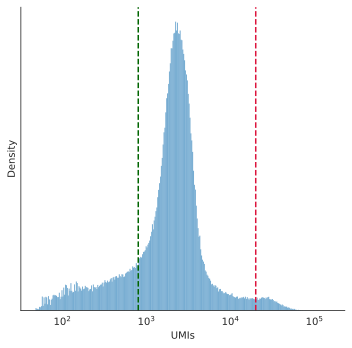

In [7]:
%%time
total_umis_per_cell = mc.ut.get_o_numpy(full, "__x__", sum=True)
plot = sb.displot(total_umis_per_cell, log_scale=(10, None))
plot.set(xlabel="UMIs", ylabel="Density", yticks=[])

plot.refline(x=PROPERLY_SAMPLED_MIN_CELL_TOTAL, color="darkgreen")
plot.refline(x=PROPERLY_SAMPLED_MAX_CELL_TOTAL, color="crimson")

plt.savefig("output/one-pass/preliminary/figures/cell_total_umis.svg")

too_small_cells_count = np.sum(total_umis_per_cell < PROPERLY_SAMPLED_MIN_CELL_TOTAL)
too_large_cells_count = np.sum(total_umis_per_cell > PROPERLY_SAMPLED_MAX_CELL_TOTAL)

total_umis_per_cell = mc.ut.get_o_numpy(full, name="__x__", sum=True)
too_small_cells_percent = 100.0 * too_small_cells_count / full.n_obs
too_large_cells_percent = 100.0 * too_large_cells_count / full.n_obs

print(
    f"Will exclude {too_small_cells_count} ({too_small_cells_percent:.2f}%%) cells"
    f" with less than {PROPERLY_SAMPLED_MIN_CELL_TOTAL} UMIs"
)
print(
    f"Will exclude {too_large_cells_count} ({too_large_cells_percent:.2f}%%) cells"
    f" with more than {PROPERLY_SAMPLED_MAX_CELL_TOTAL} UMIs"
)

#### 3.2.2 Excluding genes by name

The next decision we need to make is which genes to exclude from the data, by their names.
The poster children for this are mytochondrial genes and strong sex-specific genes. Here we also exclude the non-coding `NEAT1` gene.

In the iterative process, we may discover additional genes to exclude later on. Here in the one-pass vignette, we assume we have the right list from the start. Realistically, one would start with a list that was used for similar data in the past, and possibly tweak it later as needed.

In [8]:
EXCLUDED_GENE_NAMES = [
    "XIST", "MALAT1",   # Sex-specific genes.
    "NEAT1"             # Non-coding.
]
EXCLUDED_GENE_PATTERNS = ["MT-.*"]  # Mytochondrial.

We'll instruct the package to exclude the genes we have chosen.
By default, the code will also automatically exclude a few additional genes,
specifically genes with very high variance that are not correlated with any other gene (`bursty_lonely_gene`, see the documentation for details).
Such genes are useless for grouping cells together;
even worse, including them is actively harmful as they cause cells to appear to be deviants
(have a gene in which they are very different from the rest of the cells in the same metacell),
and thereby be marked as outliers.

In [9]:
%%time
mc.pl.exclude_genes(
    full,
    excluded_gene_names=EXCLUDED_GENE_NAMES, 
    excluded_gene_patterns=EXCLUDED_GENE_PATTERNS,
    random_seed=123456,
)

set hca_bm.full.var[bursty_lonely_gene]: 0 true (0%) out of 33694 bools
set hca_bm.full.var[properly_sampled_gene]: 27277 true (80.96%) out of 33694 bools
set hca_bm.full.var[excluded_gene]: 6433 true (19.09%) out of 33694 bools


CPU times: user 33.7 s, sys: 21.7 s, total: 55.4 s
Wall time: 39.8 s


#### 3.2.3 Excluding cells by high excluded gene UMIs

The next decision we need to make is which cells to exclude due to
containing too many UMIs in the excluded genes.
If a cell contains "too many" excluded (mainly mytochondrial) gene UMIs,
this may indicate a badly sampled cell, leading to very skewed results.
Again, the exact threshold depends on both the technology and the dataset.
Here we resort to looking at the distribution of the fraction of excluded genes in each cell,
and manually picking the threshold.

We start by computing the total UMIs of excluded genes in each cell.
We only need to do this once (as long as we don't change the list of excluded genes).

In [10]:
%%time
mc.tl.compute_excluded_gene_umis(full)

set hca_bm.full.obs[excluded_umis]: 378000 float32s


CPU times: user 3.69 s, sys: 5.07 s, total: 8.76 s
Wall time: 8.76 s


Next we'll pick a maximal fraction of excluded UMIs in each cell.

In [11]:
PROPERLY_SAMPLED_MAX_EXCLUDED_GENES_FRACTION = 0.25

We can visualize the cell excluded genes fraction threshold decision and adjust it accordingly:

Will exclude 36458 (9.64%) cells with more than 25.00% excluded gene UMIs
CPU times: user 1.3 s, sys: 491 ms, total: 1.79 s
Wall time: 1.36 s


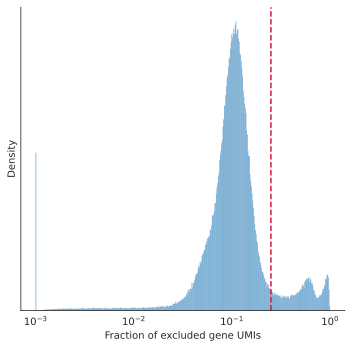

In [12]:
%%time
excluded_umis_fraction_regularization = 1e-3  # Avoid 0 values in log scale plot.
excluded_umis_per_cell = mc.ut.get_o_numpy(full, "excluded_umis")
excluded_umis_fraction_per_cell = excluded_umis_per_cell / total_umis_per_cell

excluded_umis_fraction_per_cell += excluded_umis_fraction_regularization
plot = sb.displot(excluded_umis_fraction_per_cell, log_scale=(10, None))
excluded_umis_fraction_per_cell -= excluded_umis_fraction_regularization

plot.set(xlabel="Fraction of excluded gene UMIs", ylabel="Density", yticks=[])
plot.refline(x=PROPERLY_SAMPLED_MAX_EXCLUDED_GENES_FRACTION, color="crimson")

plt.savefig("output/one-pass/preliminary/figures/cell_excluded_umis_fraction.svg")

too_excluded_cells_count = np.sum(
    excluded_umis_fraction_per_cell > PROPERLY_SAMPLED_MAX_EXCLUDED_GENES_FRACTION
)
too_excluded_cells_fraction = too_excluded_cells_count / full.n_obs

print(
    f"Will exclude {too_excluded_cells_count} ({100 * too_excluded_cells_fraction:.2f}%) cells"
    f" with more than {100 * PROPERLY_SAMPLED_MAX_EXCLUDED_GENES_FRACTION:.2f}% excluded gene UMIs"
)

We can now instruct the package to exclude the cells we have chosen.

In [13]:
%%time
mc.pl.exclude_cells(
    full,
    properly_sampled_min_cell_total=PROPERLY_SAMPLED_MIN_CELL_TOTAL,
    properly_sampled_max_cell_total=PROPERLY_SAMPLED_MAX_CELL_TOTAL,
    properly_sampled_max_excluded_genes_fraction=PROPERLY_SAMPLED_MAX_EXCLUDED_GENES_FRACTION,
    additional_cells_masks=["|doublet_cell"]
)

set hca_bm.full.obs[properly_sampled_cell]: 297810 true (78.79%) out of 378000 bools
set hca_bm.full.obs[excluded_cell]: 81387 true (21.53%) out of 378000 bools


CPU times: user 5.09 ms, sys: 995 µs, total: 6.08 ms
Wall time: 5.14 ms


### 3.3 Extract the clean data

Having decided on which cells and genes to exclude, we can now extract the clean data out of the full dataset.

In [14]:
%%time
clean = mc.pl.extract_clean_data(full, name="hca_bm.one-pass.clean")
mc.ut.top_level(clean)
print(f"Clean: {clean.n_obs} cells, {clean.n_vars} genes")

set hca_bm.one-pass.clean.obs[full_cell_index]: 296613 int32s
set hca_bm.one-pass.clean.var[full_gene_index]: 27261 int32s


Clean: 296613 cells, 27261 genes
CPU times: user 30.7 s, sys: 20.9 s, total: 51.6 s
Wall time: 51.6 s


### 3.4 Save the data

It is good practice keep the pristine input data in case we'll need to do something else with it.
We'll therefore save a copy of the "full" data with the manual annotations we have collected,
as well as the "clean" data we extracted from it. We do this prior to computing metacells, which will add further annotations, so we'll be able to easily go back to the unannotated versions of the data if (realistically, when) we revise our decisions.

Using `AnnData`, this is a full copy of the data;
when we'll switch to `DAF` we'll be able to just store the additional annotations we made, which would take practically no space and be much faster.

In [15]:
%%time
full.write_h5ad("output/one-pass/preliminary/hca_bm.full.h5ad")
full = None  # Allow it to be gc-ed

CPU times: user 930 ms, sys: 38.7 s, total: 39.6 s
Wall time: 1min 16s


In [16]:
%%time
clean.write_h5ad("output/one-pass/preliminary/hca_bm.clean.h5ad")

CPU times: user 330 ms, sys: 20.4 s, total: 20.8 s
Wall time: 48.2 s


## 4. Compute the metacells

We'll rename our data to "cells" to distinguish it from the metacells we are about to compute. We'll be adding annotations to this data (most importantly, the metacell each cell belongs to), and will later save it separately from the "clean" data we saved above.

In [17]:
%%time
cells = clean
clean = None  # Allow it to be gc-ed
mc.ut.set_name(cells, "hca_bm.one-pass.preliminary.cells")
print(f"Input: {cells.n_obs} cells, {cells.n_vars} genes")

Input: 296613 cells, 27261 genes
CPU times: user 42 µs, sys: 73 µs, total: 115 µs
Wall time: 97.3 µs


### 4.1 Decisions

Even though we have the clean cells data, we can't compute metacells for it before making a few more decisions.

#### 4.1.1 Lateral genes

A crucial decision when running metacells is the list of genes are lateral,
that is, should **not** be used to group cells together.
The poster child for this are cell-cycle genes.
These genes are strong and any clustering algorithm will therefore prefer to group together cells in the same cell-cycle state,
at the expense of mixing up other (reasonably close) cell states,
which are what we are actually interested in.
Note that lateral genes are still used in deviant cell detection,
that is, each lateral gene should still have a consistent expression level in all the cells in each metacell.

In the iterative process, we start with a very short list of genes we have a strong a-priori opinion about, expand it, and then iteratively add more genes until we settle on the final list. Here in the one-pass vignette, we assume we have the right list from the start. Realistically, one could start with a list that was used for similar data in the past, and possibly tweak it later as needed.

In [18]:
LATERAL_GENE_NAMES = [
    "ACSM3", "ANP32B", "APOE", "AURKA", "B2M", "BIRC5", "BTG2", "CALM1", "CD63", "CD69", "CDK4",
    "CENPF", "CENPU", "CENPW", "CH17-373J23.1", "CKS1B", "CKS2", "COX4I1", "CXCR4", "DNAJB1",
    "DONSON", "DUSP1", "DUT", "EEF1A1", "EEF1B2", "EIF3E", "EMP3", "FKBP4", "FOS", "FOSB", "FTH1",
    "G0S2", "GGH", "GLTSCR2", "GMNN", "GNB2L1", "GPR183", "H2AFZ", "H3F3B", "HBM", "HIST1H1C",
    "HIST1H2AC", "HIST1H2BG", "HIST1H4C", "HLA-A", "HLA-B", "HLA-C", "HLA-DMA", "HLA-DMB",
    "HLA-DPA1", "HLA-DPB1", "HLA-DQA1", "HLA-DQB1", "HLA-DRA", "HLA-DRB1", "HLA-E", "HLA-F", "HMGA1",
    "HMGB1", "HMGB2", "HMGB3", "HMGN2", "HNRNPAB", "HSP90AA1", "HSP90AB1", "HSPA1A", "HSPA1B",
    "HSPA6", "HSPD1", "HSPE1", "HSPH1", "ID2", "IER2", "IGHA1", "IGHA2", "IGHD", "IGHG1", "IGHG2",
    "IGHG3", "IGHG4", "IGHM", "IGKC", "IGKV1-12", "IGKV1-39", "IGKV1-5", "IGKV3-15", "IGKV4-1",
    "IGLC2", "IGLC3", "IGLC6", "IGLC7", "IGLL1", "IGLL5", "IGLV2-34", "JUN", "JUNB", "KIAA0101",
    "LEPROTL1", "LGALS1", "LINC01206", "LTB", "MCM3", "MCM4", "MCM7", "MKI67", "MT2A", "MYL12A",
    "MYL6", "NASP", "NFKBIA", "NUSAP1", "PA2G4", "PCNA", "PDLIM1", "PLK3", "PPP1R15A", "PTMA",
    "PTTG1", "RAN", "RANBP1", "RGCC", "RGS1", "RGS2", "RGS3", "RP11-1143G9.4", "RP11-160E2.6",
    "RP11-53B5.1", "RP11-620J15.3", "RP5-1025A1.3", "RP5-1171I10.5", "RPS10", "RPS10-NUDT3", "RPS11",
    "RPS12", "RPS13", "RPS14", "RPS15", "RPS15A", "RPS16", "RPS17", "RPS18", "RPS19", "RPS19BP1",
    "RPS2", "RPS20", "RPS21", "RPS23", "RPS24", "RPS25", "RPS26", "RPS27", "RPS27A", "RPS27L",
    "RPS28", "RPS29", "RPS3", "RPS3A", "RPS4X", "RPS4Y1", "RPS4Y2", "RPS5", "RPS6", "RPS6KA1",
    "RPS6KA2", "RPS6KA2-AS1", "RPS6KA3", "RPS6KA4", "RPS6KA5", "RPS6KA6", "RPS6KB1", "RPS6KB2",
    "RPS6KC1", "RPS6KL1", "RPS7", "RPS8", "RPS9", "RPSA", "RRM2", "SMC4", "SRGN", "SRSF7", "STMN1",
    "TK1", "TMSB4X", "TOP2A", "TPX2", "TSC22D3", "TUBA1A", "TUBA1B", "TUBB", "TUBB4B", "TXN", "TYMS",
    "UBA52", "UBC", "UBE2C", "UHRF1", "YBX1", "YPEL5", "ZFP36", "ZWINT"
]
LATERAL_GENE_PATTERNS = ["RP[LS].*"]  # Ribosomal

In [19]:
%%time
# This will mark as "lateral_gene" any genes that match the above, if they exist in the clean dataset.
mc.pl.mark_lateral_genes(
    cells,
    lateral_gene_names=LATERAL_GENE_NAMES,
    lateral_gene_patterns=LATERAL_GENE_PATTERNS,
)

lateral_gene_mask = mc.ut.get_v_numpy(cells, "lateral_gene")
lateral_gene_names = set(cells.var_names[lateral_gene_mask])
print(sorted([name for name in lateral_gene_names if not name.startswith("RPL") and not name.startswith("RPS")]))
print(f"""and {len([
    name for name in lateral_gene_names if name.startswith("RPL") or name.startswith("RPS")
])} RP[LS].* genes""")

set hca_bm.one-pass.preliminary.cells.var[lateral_gene]: 257 true (0.9427%) out of 27261 bools


['ACSM3', 'ANP32B', 'APOE', 'AURKA', 'B2M', 'BIRC5', 'BTG2', 'CALM1', 'CD63', 'CD69', 'CDK4', 'CENPF', 'CENPU', 'CENPW', 'CH17-373J23.1', 'CKS1B', 'CKS2', 'COX4I1', 'CXCR4', 'DNAJB1', 'DONSON', 'DUSP1', 'DUT', 'EEF1A1', 'EEF1B2', 'EIF3E', 'EMP3', 'FKBP4', 'FOS', 'FOSB', 'FTH1', 'G0S2', 'GGH', 'GLTSCR2', 'GMNN', 'GNB2L1', 'GPR183', 'H2AFZ', 'H3F3B', 'HBM', 'HIST1H1C', 'HIST1H2AC', 'HIST1H2BG', 'HIST1H4C', 'HLA-A', 'HLA-B', 'HLA-C', 'HLA-DMA', 'HLA-DMB', 'HLA-DPA1', 'HLA-DPB1', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DRA', 'HLA-DRB1', 'HLA-E', 'HLA-F', 'HMGA1', 'HMGB1', 'HMGB2', 'HMGB3', 'HMGN2', 'HNRNPAB', 'HSP90AA1', 'HSP90AB1', 'HSPA1A', 'HSPA1B', 'HSPA6', 'HSPD1', 'HSPE1', 'HSPH1', 'ID2', 'IER2', 'IGHA1', 'IGHA2', 'IGHD', 'IGHG1', 'IGHG2', 'IGHG3', 'IGHG4', 'IGHM', 'IGKC', 'IGKV1-12', 'IGKV1-39', 'IGKV1-5', 'IGKV3-15', 'IGKV4-1', 'IGLC2', 'IGLC3', 'IGLC6', 'IGLC7', 'IGLL1', 'IGLL5', 'IGLV2-34', 'JUN', 'JUNB', 'KIAA0101', 'LEPROTL1', 'LGALS1', 'LINC01206', 'LTB', 'MCM3', 'MCM4', 'MCM7', 'MKI67',

#### 4.1.2 Noisy genes

Another important list of genes are the genes with higher than usual variance,
which will cause a lot of cells to be deviant (inconsistent with their metacells),
and therefore be marked as deviants (outliers). Marking them as "noisy" allows for more variance for these genes in each metacell, reducing the number of such outliers.

In the iterative process, we typically start with an empty list of genes, and then iteratively add more genes until we settle on the final list. Here in the one-pass vignette, we assume we have the right list from the start. Realistically, one could start with a list that was used for similar data in the past, and possiblly tweak it later as needed.

In [20]:
NOISY_GENE_NAMES = [
    "CCL3", "CCL4", "CCL5", "CXCL8", "DUSP1", "FOS", "G0S2", "HBB", "HIST1H4C", "IER2", "IGKC",
    "IGLC2", "JUN", "JUNB", "KLRB1", "MT2A", "RPS26", "RPS4Y1", "TRBC1", "TUBA1B", "TUBB"
]

In [21]:
%%time
# This will mark as "noisy_gene" any genes that match the above, if they exist in the clean dataset.
mc.pl.mark_noisy_genes(cells, noisy_gene_names=NOISY_GENE_NAMES)

set hca_bm.one-pass.preliminary.cells.var[noisy_gene]: 21 true (0.07703%) out of 27261 bools


CPU times: user 7.2 ms, sys: 230 µs, total: 7.43 ms
Wall time: 7.24 ms


#### 4.1.3 Parallelization

Finally, we need to decide on how much parallelization to use.
This is a purely technical decision - it does not affect the results, just the performance.

The more parallel piles we use, the faster the computation will be
(up to the number of physical processors, but that is handled automatically for us).

However, having more parallel piles means using more memory.
If we run out of memory, we'll need to reduce the number of parallel piles.
You can track the memory usage by running `top` or `htop` during the computation.

We provide a guesstimator for the maximal number of parallel piles that will fit in memory.
This is by no means perfect, but it is a starting point.

In [22]:
%%time
# Either use the guesstimator:
max_parallel_piles = mc.pl.guess_max_parallel_piles(cells)
# Or, if running out of memory manually override:
# max_paralle_piles = ...
print(max_parallel_piles)
mc.pl.set_max_parallel_piles(max_parallel_piles)

498
CPU times: user 8.19 s, sys: 1.41 s, total: 9.6 s
Wall time: 9.6 s


### 4.2 Computation

We are (*finally*) ready to actually group the cells into metacells.

#### 4.2.1 Hyper-parameters

The metacells pipeline has a *lot* of hyper parameters you can tweak. The defaults were chosen such that scRNA-seq data, especially 10x data, should work "well" out of the box. You should read the documentation and have a good understanding of the effect of anny parameter you may want to tweak, keeping in mind the synergy between some of the parameters.

If we had to call out one hyper-parameter you *might* wish to tweak, it would be the `target_metacell_size`. This specifies the "ideal" number of cells in each metacell. The algorithm works hard to keep the actual metacell size close to this value - in particular, metacells larger than twice this size will be split, and metacells which are much smaller than this size will be merged, or dissolved (become outliers).

By default this value is set to `96`. Setting it to a smaller value will create more metacells, which may allow capturing more subtle differences between cell states (e.g. along a gradient); this, however, would come at the cost of making less robust estimations of each gene's expression level in each metacell. This *might* be a worthwhile tradeoff if your cells are of higher quality.

One technical "hyper-paramater" you *must* specify is the `random_seed`. A non-zero value will genenrate reproducible results. A zero value will generate non-reproducible results and will be *slightly* faster. We "strongly urge" you to use a non-zero as reproducible results are *much* easier to deal with.

#### 4.2.2 Assigning cells to metacells

This is the core of the method.
It can take a while.
The dataset used in this example is far from trivial - it contains ~1/3M cells.
This takes ~10 minutes to compute on a hefty (48 HT cores, 0.5TB RAM) server.
You can see progress is being made by running the computation with a progress bar.
This progress is rather non-linear,
for example there's a pause at the start when computing rare gene modules,
and it isn't smooth afterwards either.
You can skip it alltogether by getting rid of the `with` statement.

In [23]:
%%time
with mc.ut.progress_bar():
    mc.pl.divide_and_conquer_pipeline(cells, random_seed=123456)

Detect rare gene modules...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉[04:47]

CPU times: user 3min 22s, sys: 1min 26s, total: 4min 49s
Wall time: 5min 23s


#### 4.2.3 Collecting the metacells

The above merely computed a metacell name and index for each cell ("Outliers" and negative for outlier cells). We still need to collect all the cells of each metacell, to create a new `AnnData` where each profile is a metacell. Note that in this new metacells data, we no longer have UMIs per gene; instead, for each gene, we have an estimate of the fraction of its UMIs out of the total UMIs. Since `AnnData` can only hold a single 2D dataset, the result must be a separate object (with each "observation" being a metacell), so we copy all the per-gene annotations from the cells dataset to the result.

In [24]:
%%time
metacells = \
    mc.pl.collect_metacells(cells, name="hca_bm.one-pass.preliminary.metacells", random_seed=123456)
print(f"Preliminary: {metacells.n_obs} metacells, {metacells.n_vars} genes")

set hca_bm.one-pass.preliminary.metacells.obs[grouped]: 3144 int64s
set hca_bm.one-pass.preliminary.metacells.obs[total_umis]: 3144 float64s
set hca_bm.one-pass.preliminary.metacells.layers[total_umis]: ndarray 3144 X 27261 float32s
set hca_bm.one-pass.preliminary.metacells.obs[__zeros_downsample_umis]: 3144 int64s
set hca_bm.one-pass.preliminary.metacells.layers[zeros]: ndarray 3144 X 27261 int32s
set hca_bm.one-pass.preliminary.cells.obs[metacell_name]: 296613 <U8s
set hca_bm.one-pass.preliminary.metacells.var[gene_ids]: 27261 objects
set hca_bm.one-pass.preliminary.metacells.var[bursty_lonely_gene]: 0 true (0%) out of 27261 bools
set hca_bm.one-pass.preliminary.metacells.var[properly_sampled_gene]: 27261 true (100%) out of 27261 bools
set hca_bm.one-pass.preliminary.metacells.var[excluded_gene]: 0 true (0%) out of 27261 bools
set hca_bm.one-pass.preliminary.metacells.var[full_gene_index]: 27261 int32s
set hca_bm.one-pass.preliminary.metacells.var[lateral_gene]: 257 true (0.9427%) ou

Preliminary: 3144 metacells, 27261 genes
CPU times: user 9.82 s, sys: 26 s, total: 35.8 s
Wall time: 44 s


If the input data contains per-cell annotations of interest,
then here would be a good place to convey that data to the metacells object.
Since each metacell is a combination of multiple cells,
this requires a decision on how exactly to do this for each per-cell annotation.
We can either reduce the multiple per-cell values into a single one
(such as the most frequent value or the mean value),
or we can collect the fraction of cells that have each value in each metacell (for categorical data).
Since `AnnData` is limited to simple 2D data,
the latter is implemented as a series of per-metacell annotations (one for each possible value).
This will be handled better in `DAF`.

In [25]:
%%time
# Assign a single value for each metacell based on the cells.
mc.tl.convey_obs_to_group(
    adata=cells, gdata=metacells,
    property_name="donor_organism.organism_age", to_property_name="sex",
    method=mc.ut.most_frequent  # This is the default, for categorical data
)
mc.tl.convey_obs_to_group(
    adata=cells, gdata=metacells,
    property_name="donor_organism.organism_age", to_property_name="age",
    method=np.mean
)
# Compute the fraction of cells with each possible value in each metacell:
mc.tl.convey_obs_fractions_to_group(
    adata=cells, gdata=metacells,
    property_name="donor_organism.sex", to_property_name="sex"
)
mc.tl.convey_obs_fractions_to_group(  # Age has just a few possible values so treat it as categorical.
    adata=cells, gdata=metacells,
    property_name="donor_organism.organism_age", to_property_name="age"
)
mc.tl.convey_obs_fractions_to_group(adata=cells, gdata=metacells, property_name="donor")
mc.tl.convey_obs_fractions_to_group(adata=cells, gdata=metacells, property_name="batch")

set hca_bm.one-pass.preliminary.metacells.obs[sex]: 3144 float32s
set hca_bm.one-pass.preliminary.metacells.obs[age]: 3144 float32s
set hca_bm.one-pass.preliminary.metacells.obs[sex_fraction_of_female]: 3144 float64s
set hca_bm.one-pass.preliminary.metacells.obs[sex_fraction_of_male]: 3144 float64s
set hca_bm.one-pass.preliminary.metacells.obs[age_fraction_of_26.0]: 3144 float64s
set hca_bm.one-pass.preliminary.metacells.obs[age_fraction_of_29.0]: 3144 float64s
set hca_bm.one-pass.preliminary.metacells.obs[age_fraction_of_32.0]: 3144 float64s
set hca_bm.one-pass.preliminary.metacells.obs[age_fraction_of_36.0]: 3144 float64s
set hca_bm.one-pass.preliminary.metacells.obs[age_fraction_of_39.0]: 3144 float64s
set hca_bm.one-pass.preliminary.metacells.obs[age_fraction_of_50.0]: 3144 float64s
set hca_bm.one-pass.preliminary.metacells.obs[age_fraction_of_52.0]: 3144 float64s
set hca_bm.one-pass.preliminary.metacells.obs[donor_fraction_of_MantonBM1]: 3144 float64s
set hca_bm.one-pass.prelimina

CPU times: user 24.9 s, sys: 325 ms, total: 25.3 s
Wall time: 25.2 s


### 4.3 Computing for MCView

So we have our metacells data. This is pretty opaque as of itself.
`MCView` is our interactive tool for exploring the data, and for assigning type labels to the metacells.

However, in order to use `MCView`, we first need to compute all sort of quality control data for `MCView` to display.
This again may take a while (but much less then computing the metacells above).

In [26]:
%%time
with mc.ut.progress_bar():
    mc.pl.compute_for_mcview(adata=cells, gdata=metacells, random_seed=123456)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉[04:27]

CPU times: user 1h 47min 54s, sys: 2min 24s, total: 1h 50min 18s
Wall time: 4min 27s


Here's a preview of the 2D UMAP view of the data (without any color annotations, as we do not have type annotations yet):

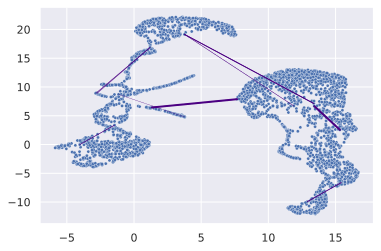

CPU times: user 1.25 s, sys: 5.08 s, total: 6.33 s
Wall time: 279 ms


In [27]:
%%time
min_long_edge_size = 4
umap_x = mc.ut.get_o_numpy(metacells, "x")
umap_y = mc.ut.get_o_numpy(metacells, "y")
umap_edges = sp.coo_matrix(mc.ut.get_oo_proper(metacells, "obs_outgoing_weights"))
sb.set()
plot = sb.scatterplot(x=umap_x, y=umap_y, s=10)
for (
    source_index, target_index, weight
) in zip(
    umap_edges.row, umap_edges.col, umap_edges.data
):
    source_x = umap_x[source_index]
    target_x = umap_x[target_index]
    source_y = umap_y[source_index]
    target_y = umap_y[target_index]
    if hypot(target_x - source_x, target_y - source_y) >= min_long_edge_size:
        plt.plot([source_x, target_x], [source_y, target_y],
                 linewidth=weight * 2, color='indigo')
plt.show()

### 4.4 Saving the data

We'll save the results on disk for future reference, and to allow them to be imported into `MCView`.

In [28]:
%%time
cells.write_h5ad("output/one-pass/preliminary/hca_bm.cells.h5ad")

CPU times: user 1.24 s, sys: 25.1 s, total: 26.4 s
Wall time: 49.9 s


In [29]:
%%time
metacells.write_h5ad("output/one-pass/preliminary/hca_bm.metacells.h5ad")

CPU times: user 245 ms, sys: 603 ms, total: 848 ms
Wall time: 2.96 s


## 5. Importing into MCView

This vignette focuses on the metacells package, not `MCView`, which deserves a full vignette of its own. Still, here are some basics about how to use it.

### 5.1 Installing MCView

The `MCView` is written in `R` but is not a standard CRAN package.
To install it, you should type (**in `R`**):

```R
install.packages("remotes")
remotes::install_github("tanaylab/MCView")
```

### 5.2 Importing data set

Since `MCView` is written in `R`, it isn't easy to run it inside a Python notebook.
Instead we've provided a small `R` script that will load the data we saved above,
and import it into an `MCView` application. Here is the code of the script for reference:

```R
library("MCView")

args <- commandArgs(trailingOnly=TRUE)
stopifnot(length(args) == 3 || length(args) == 4)
prefix <- args[1]
name <- args[2]
title <- args[3]

if (length(args) == 4) {
    type <- args[4]
    import_dataset(
        sprintf("mcview/%s", prefix, name),                   # The directory to create
        sprintf("%s-%s", prefix, gsub("/", "-", name)),       # The name of the dataset
        sprintf("output/%s/%s.metacells.h5ad", name, prefix), # The metacells h5ad file
        metadata_fields = "all",                              # Ask to import all the metadata
        title = title,                                        # A title for the GUI
        cell_type_field = type,                               # The name of the type field
        cell_type_colors_file = "captured/type_colors.csv"    # The type colors CSV file
    )

} else {
    import_dataset(
        sprintf("mcview/%s.%s", prefix, name),                # The directory to create
        sprintf("%s-%s", prefix, gsub("/", "-", name)),       # The name of the dataset
        sprintf("output/%s/%s.metacells.h5ad", name, prefix), # The metacells h5ad file
        metadata_fields = "all",                              # Ask to import all the metadata
        title = title                                         # A title for the GUI
    )
}
```

We'll just run it as an external process using `Rscript`:

In [44]:
%%time
os.system("Rscript scripts/import_dataset.r hca_bm one-pass/preliminary 'HCABM 1P|PRE'")

ℹ creating mcview/one-pass/preliminary
→ You can edit the app configuration at 'mcview/one-pass/preliminary/config/config.yaml'
ℹ Importing hca_bm-one-pass-preliminary
ℹ Reading 'output/one-pass/preliminary/hca_bm.metacells.h5ad'
ℹ Processing metacell matrix
ℹ Processing 2d projection
ℹ Calculating top genes per metacell (marker genes)
ℹ Calculating metacell correlations of default marker genes
ℹ Processing inner-folds matrix
ℹ Calculating top inner-fold genes
→ Added the Inner-fold tab to the config file. To change the tab order or remove it - edit the tabs section at: 'mcview/one-pass/preliminary/config/config.yaml'
ℹ Processing inner-stdev matrix
ℹ Calculating top inner-stdev genes
→ Added the Stdev-fold tab to the config file. To change the tab order or remove it - edit the tabs section at: 'mcview/one-pass/preliminary/config/config.yaml'
ℹ Clustering in order to get initial annotation.
ℹ using 168 genes
ℹ clustering k = 64
ℹ number of features = 168
ℹ Generating cell type colors u

CPU times: user 8.47 ms, sys: 190 ms, total: 199 ms
Wall time: 1min 18s


0

### 5.3 Running MCView

The simplest way to run `MCView` is, in `R`, to type:
    
```R
library(MCView)
run_app("mcview/one-pass/preliminary") # The path we imported the dataset into
```

Since `MCView` is a [shiny](https://shiny.posit.co/) application, you have many other options, which are outside the scope of this vignette.

#### 5.4 Reviewing gene lists decisions in MCView

To review the list of lateral genes, we look at the markers heatmap and look for genes that separate between different cell types, but we have prior biological knowledge that they actually indicate unrelated programs such as cell cycle, viral load, stress, etc.

To review the list of noisy genes, we look at the QC "# metacells with significant inner fold" scatter plot and look for genes which are highly variable in many metacells.

In the one-pass vignette we'll assume that we do not need to revise these gene lists, as opposed to the iterative process vignette where we repeatedly update these lists during the iterations.

##### 5.5 Annotating types in MCView

The basic procedure we use for annotating metacell types is to look at the markers heatmap to identify interesting genes, and then using the gene-gene plots to identify groups of metacells that present the right combination of markers to justify some type label. Here's an example gene-gene plot showing a gradient between HSC (Hematopoietic Stem Cell)
and LMPP (Lymphoid-primed Multipotent Progenitors):

![HLF-AVP](../images/gene-gene.HLF-AVP.svg)

If some metacells express a combination of markers for two unrelated types, we will consider labeling them as doublets. All these decisions require prior biological knowledge of the genes and the system. Here's an example of a doublet metacell containing a mixture of Ery (erythrocytes) and T-cells:

![HBB-TRBC1](../images/gene-gene.HBB-TRBC1.svg)

To kickstart the process, `MCView` will automatically cluster the metacells innto some groups, and give a color to each. This makes the markers heatmap at least somewhat informative even before manual type annotation has begun. Note these clusters arejust as a very crude starting point. Sometimes a cluster will map well to a single cell type, but most likely, a cell type would contain metacells from several clusters, or a cluster will need to be split between two cell types.

#### 5.6 Updating types in MCView

The `MCView` application is stateless, that is, any type annotations created in it are not persistent. If you close your browser's window, any annotations you made will be lost, unless you first export the types as a CSV file. You can then start a new instance of the application in your browser and import this file back to continue where you left off. We saved a copy of this exported file in `captured/one-pass.preliminary.types.csv` which we'll use below.

You can also export a small convenience file which just contains the mapping between types and colors. In this vignette we'll assume this mapping does not change between the applications. We saved a copy of this file in `captured/type_colors.csv` - in fact, you will notice that we use this in the `scripts/import_dataset.r` script above when we create applications with type annotations already embedded in them.

These `MCView` mechanisms make it easy for a web server to deal with multiple simultaneous users which may modifying things at the same time. For the web server, the application files are read-only, which is exactly what you want when publishing data for users to see. This even allows the users to work on alternative type annotations without impacting each another.

However, this makes it more difficult for a single user which actively edits the data. The way around it is to do embed the exported file into the application's directory, that is, modify the application's disk files. From that point on, all users that will open the application will see the new type annotations.

We'll do this now, using the following simple script:

```R
library("MCView")

args <- commandArgs(trailingOnly=TRUE)
stopifnot(length(args) == 2)
name <- args[1]
types <- args[2]

update_metacell_types(
    sprintf("mcview/%s", name),                  # The directory of the app
    sprintf("hca_bm-%s", gsub("/", "-", name)),  # The name of the dataset
    types                                        # The types CSV files
)
```

In [45]:
%%time
os.system("Rscript scripts/update_types.r one-pass/preliminary captured/one-pass.preliminary.types.csv")

CPU times: user 121 µs, sys: 185 ms, total: 185 ms
Wall time: 2.44 s


✔ Succesfully changed metacell cell type assignments
ℹ File has a field named 'color', updating also cell type colors.
✔ Succesfully changed cell type color assignments


0

## 6. Applying type annotations from MCView

### 6.1 Reading the data

The `MCView` application is stateless, that is, any type annotations created in it are not persistent. You must export them (as a CSV file). What we'll do here is read this data, and embed it into out data set, so that it will be available for later analysis. 

In [32]:
%%time
metacell_types_csv = pd.read_csv("captured/one-pass.preliminary.types.csv")
assert np.all(metacell_types_csv["metacell"] == metacells.obs_names)

CPU times: user 3.38 ms, sys: 5.96 ms, total: 9.34 ms
Wall time: 8.54 ms


### 6.2 Conveying type annotations

We'll now apply these type annotations to both the metacells and the cells:

In [33]:
%%time
type_of_metacell = np.array(metacell_types_csv["cell_type"])
mc.ut.set_o_data(metacells, "type", type_of_metacell)

extended_type_of_metacell = pd.Series(
    list(type_of_metacell) + ["Outliers"],
    index=list(metacell_types_csv["metacell"]) + ["Outliers"]
)

metacell_of_cell = cells.obs["metacell_name"]
type_of_cell = np.array(extended_type_of_metacell[metacell_of_cell])
mc.ut.set_o_data(cells, "type", type_of_cell)

set hca_bm.one-pass.preliminary.metacells.obs[type]: 3144 objects
set hca_bm.one-pass.preliminary.cells.obs[type]: 296613 objects


CPU times: user 49.4 ms, sys: 6.58 ms, total: 56 ms
Wall time: 55 ms


### 6.3 Removing doublet meta/cells

Some of the metacells were annotated as doublets. In the full iterative process, we would exclude the cells of these metacells, re-compute the metacells, and re-annotate them. Here in the one-pass vignette, we remove the cells, and also remove the metacells, and stop at that. This is "OK", but recomputing (and re-annotating) the metacells will give better results at the cost of additional effort.

In [34]:
%%time
doublets_metacells_mask = type_of_metacell == "doublets"
print(f"Remove {np.sum(doublets_metacells_mask)} metacells as doublets")
metacells = mc.ut.slice(metacells, obs=~doublets_metacells_mask, name="hca_bm.metacells")
print(f"Final: {metacells.n_obs} metacells, {metacells.n_vars} genes")

Remove 10 metacells as doublets
Final: 3134 metacells, 27261 genes
CPU times: user 673 ms, sys: 181 ms, total: 854 ms
Wall time: 852 ms


In [35]:
%%time
doublets_cells_mask = type_of_cell == "doublets"
print(f"Remove {np.sum(doublets_cells_mask)} cells as doublets")
cells = mc.ut.slice(cells, obs=~doublets_cells_mask, name="hca_bm.cells")
print(f"Final (~doublets): {cells.n_obs} cells, {cells.n_vars} genes")

Remove 633 cells as doublets
Final (~doublets): 295980 cells, 27261 genes
CPU times: user 28.6 s, sys: 11.2 s, total: 39.8 s
Wall time: 39.8 s


For each cell we keep not only the `metacell_name` but also the `metacell` index. Since we've just deleted a few metacells, we'll need to patch these indices. 

In [36]:
%%time
new_metacell_of_old_metacell = np.cumsum(~doublets_metacells_mask) - 1
old_metacell_of_cells = mc.ut.get_o_numpy(cells, "metacell")
new_metacell_of_cells = new_metacell_of_old_metacell[old_metacell_of_cells]
mc.ut.set_o_data(cells, "metacell", new_metacell_of_cells)

set hca_bm.cells.obs[metacell]: 295980 int64s


CPU times: user 2.5 ms, sys: 4.1 ms, total: 6.6 ms
Wall time: 5.5 ms


## 7. Finalizing the data

This is a good place to delete, rename, compute and in general ensure all per-gene and per-metacell properties exist, are properly named, etc. Again, how much effort (if any) is put into this varies greatly depending on the intended use of the final results.

### 7.1 Marking essential genes

If we are preparing a reference atlas, that is, we expect to project other data into it (as described in the projection vignette), then it is recommended to designate a few genes as "essential" for each cell type.

When we will project data onto the atlas, we'll do a lot of quality assurance to ensure the projection makes biological sense. The (optional) essential gene lists help with this quality assurance. Specifically, if a gene is designated as essential for some cell type, and some projected data "seems like" it is of this cell type, we'll ensure it agrees with the atlas for the essential genes. For example, if a projected metacell does not express CD8, then we can't say it is a CD8 T-cell. It may be very *similar* to a CD8 T-cell, but we just can't reasonably that it *is* one.

Selecting the (few) genes to use as essential for each cell type requires, as usual, the expertise of the biologist preparing the atlas. Note that all we require is a list of genes, *not* some quantitative threshold to use as a cell type classifier. The quantitative aspect is automatically provided by the projection algorithm itself (which is outside the scope of this vignette).

In [37]:
#%%time
#mc.ut.mark_essential_genes(
#    metacells,
#    essential_gene_names_of_types={ "CD8 T-cell" => ["CD8", ...], ...}
#)

### 7.2 Recomputing for MCView

We've already computed all the `MCView` data. Yes, we have added the assignment of types to metacells since, but none of the computed data actually depends on these types, so there's no need to compute it again.

We also removed some doublet metacells. Again, this doesn't impact the quality control computations, which are per-metacell. However, it does impact the UMAP 2D projection, as it is very sensitive to doublets. Typically removing them allows UMAP to generate a better 2D layout, so we'll call it again.

In general `compute_for_mcview` is just a collection of calls to (11!) lower-level quality control computation functions, which you can also call manually on your own. The `compute_umap_by_markers` is just one of these functions.

Finally, note that a nice-looking 2D UMAP is of course useful, and serves for very rudimentary quality assurance. However, we do *not* consider this to be an analysis tool. Specifically, we do not worry when this (rather arbitrary) 2D projection changes during the iterative process (or, for that matter, when recomputed here). Instead we first and foremost focus on the markers heatmap (shown in `MCView`), which shows the true complexity of the data. In other words, just skipping the recomputation of the UMAP and keeping the original one above would have been "OK" as well.

In [38]:
%%time
mc.pl.compute_umap_by_markers(metacells, random_seed=123456)

set hca_bm.metacells.obsp[obs_balanced_ranks]: 38127 nonzero (0.3882%) out of 9821956 elements
set hca_bm.metacells.obsp[obs_pruned_ranks]: 12509 nonzero (0.1274%) out of 9821956 elements
set hca_bm.metacells.obsp[obs_outgoing_weights]: 12509 nonzero (0.1274%) out of 9821956 elements
set hca_bm.metacells.obsp[umap_distances]: csr_matrix 3134 X 3134 float32s (9818822 > 0, 99.97%)
set hca_bm.metacells.obs[x]: 3134 float32s
set hca_bm.metacells.obs[y]: 3134 float32s


CPU times: user 1min 48s, sys: 13.6 s, total: 2min 1s
Wall time: 15.9 s


We'll see the results in `MCView`, but here's a preview of the UMAP (this type, with colors using the type annotations).

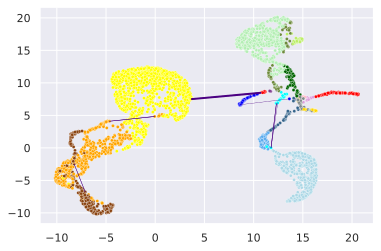

CPU times: user 408 ms, sys: 181 ms, total: 589 ms
Wall time: 395 ms


In [39]:
%%time
type_color_csv = pd.read_csv("captured/type_colors.csv")
color_of_type = pd.Series(
    list(type_color_csv["color"]) + ["magenta", "magenta"],
    index=list(type_color_csv["cell_type"]) + ["Outliers", "(Missing)"]
)
type_of_metacell = mc.ut.get_o_numpy(metacells, "type")
color_of_metacell = np.array(color_of_type[type_of_metacell])

min_long_edge_size = 4
umap_x = mc.ut.get_o_numpy(metacells, "x")
umap_y = mc.ut.get_o_numpy(metacells, "y")
umap_edges = sp.coo_matrix(mc.ut.get_oo_proper(metacells, "obs_outgoing_weights"))
sb.set()
plot = sb.scatterplot(x=umap_x, y=umap_y, color=color_of_metacell, s=10)
for (
    source_index, target_index, weight
) in zip(
    umap_edges.row, umap_edges.col, umap_edges.data
):
    source_x = umap_x[source_index]
    target_x = umap_x[target_index]
    source_y = umap_y[source_index]
    target_y = umap_y[target_index]
    if hypot(target_x - source_x, target_y - source_y) >= min_long_edge_size:
        plt.plot([source_x, target_x], [source_y, target_y],
                 linewidth=weight * 2, color='indigo')
plt.show()

### 7.4 Save the data

We'll save the final results for whatever usage we intend for them (and for importing into `MCView`).

In [40]:
%%time
metacells.write_h5ad("output/one-pass/final/hca_bm.metacells.h5ad")

CPU times: user 263 ms, sys: 656 ms, total: 919 ms
Wall time: 3.27 s


In [41]:
%%time
cells.write_h5ad("output/one-pass/final/hca_bm.cells.h5ad")

CPU times: user 2.18 s, sys: 16.4 s, total: 18.6 s
Wall time: 54.2 s


## 8. Importing into MCView

The difference between this `MCView` application and the preliminary one is that this one will know about the type annotations (and will reflect any spit-and-polish we have done in the final phase).

In [46]:
%%time
os.system("Rscript scripts/import_dataset.r hca_bm one-pass/final 'HCABM 1P|FIN' type")

ℹ creating mcview/one-pass/final
→ You can edit the app configuration at 'mcview/one-pass/final/config/config.yaml'
ℹ Importing hca_bm-one-pass-final
ℹ Reading 'output/one-pass/final/hca_bm.metacells.h5ad'
ℹ Processing metacell matrix
ℹ Processing 2d projection
ℹ Calculating top genes per metacell (marker genes)
ℹ Calculating metacell correlations of default marker genes
ℹ Processing inner-folds matrix
ℹ Calculating top inner-fold genes
→ Added the Inner-fold tab to the config file. To change the tab order or remove it - edit the tabs section at: 'mcview/one-pass/final/config/config.yaml'
ℹ Processing inner-stdev matrix
ℹ Calculating top inner-stdev genes
→ Added the Stdev-fold tab to the config file. To change the tab order or remove it - edit the tabs section at: 'mcview/one-pass/final/config/config.yaml'
ℹ Taking cell type annotations from type field in the anndata object
ℹ Loading cell type color annotations from 'captured/type_colors.csv'
ℹ Clustering in order to get gene modules.

CPU times: user 10.8 ms, sys: 230 ms, total: 240 ms
Wall time: 1min 13s


0

That's it. We now have our final results, both as `h5ad` files and as an `MCView` application, to use as we see fit.

To remove doubt, the results presented here are **not** suitable for use in any serious analysis. This is an example of the process, nothing more.